In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, precision_score, confusion_matrix,ConfusionMatrixDisplay, get_scorer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
os.environ['LOKY_MAX_CPU_COUNT'] = str(os.cpu_count()-2)

In [8]:
df = pd.read_csv('../Dataset/dataFrameProcessed')
targetCol = 'imdb_rating'
X = df.drop(columns=[targetCol])
y = df[targetCol]

In [4]:
models = {
    'Support Vector Machine': SVC(kernel='rbf', random_state=42),
    'Random Forest'         : RandomForestClassifier(random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(random_state=42),
}

In [5]:
scoringMetrics = {
    'accuracy'  : 'accuracy',
    'precision' : make_scorer(precision_score, average='weighted', zero_division=1),
    'recall'    : 'recall_weighted',
    'f1'        : 'f1_weighted'
}

Support Vector Machine
  accuracy  : 0.75600
  precision : 0.76371
  recall    : 0.75600
  f1        : 0.75194


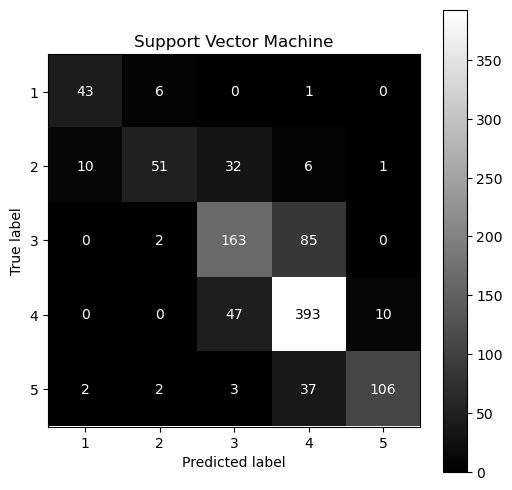



Random Forest
  accuracy  : 0.77500
  precision : 0.78376
  recall    : 0.77500
  f1        : 0.77093


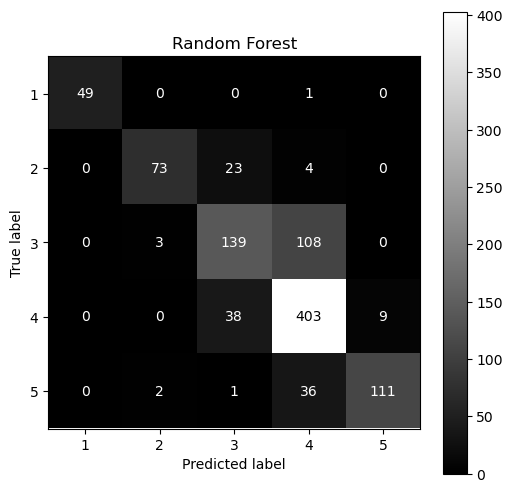



Hist Gradient Boosting
  accuracy  : 0.81900
  precision : 0.82229
  recall    : 0.81900
  f1        : 0.81885


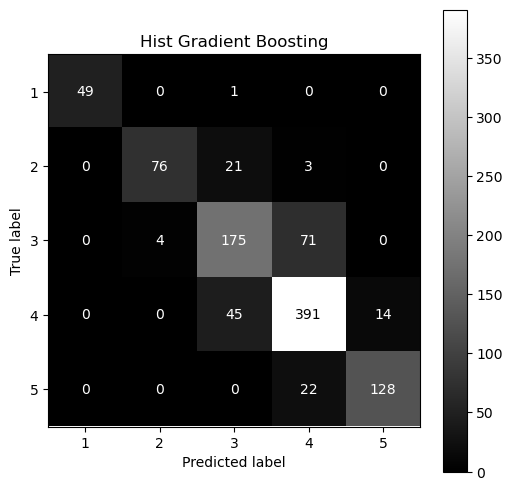

In [6]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42 , stratify=y)

for name, model in models.items():
    print(f'{name}')

    model.fit(XTrain, yTrain)

    for metricName, scorer in scoringMetrics.items():
        if isinstance(scorer, str):
            scorer = get_scorer(scorer)

        score = scorer(model, XTest, yTest)
        print(f"  {metricName:<10}: {score:.5f}")

    yPred = model.predict(XTest)
    confusionMatrix = confusion_matrix(yTest, yPred)
    display = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=model.classes_)

    fig, axes = plt.subplots(figsize=(6, 6))
    display.plot(cmap='gist_gray', ax=axes, values_format='d')
    plt.title(f'{name}')
    plt.show()

    print("\n")

In [10]:
fold = 10

In [9]:
dataset_results = []

for model_name, model in models.items():
    print(f'Running {model_name}...')

    clf = Pipeline(steps=[
        ('feature_selection', SelectFromModel(
            estimator=RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            threshold='median')
         ),
        ('classifier', model)
    ])

    try:
        cvResult = cross_validate(
            clf,
            X,
            y,
            cv= fold,
            scoring=scoringMetrics,
            n_jobs=-1,
            error_score='raise'
        )

        dataset_results.append({
            'Model'     : model_name,
            'Accuracy'  : np.mean(cvResult['test_accuracy']),
            'Precision' : np.mean(cvResult['test_precision']),
            'Recall'    : np.mean(cvResult['test_recall']),
            'F1 Score'  : np.mean(cvResult['test_f1'])
        })

    except Exception as e:
        print(f'Failed to run {model_name}. Error: {e}')

if dataset_results:
    results_df = pd.DataFrame(dataset_results).set_index('Model')
    results_df = results_df.sort_values(by="F1 Score", ascending=False)

    print('\nPerformance:\n')
    print(results_df)
else:
    print('No models ran successfully.')

Running Support Vector Machine...
Running Random Forest...
Running Hist Gradient Boosting...

Performance:

                        Accuracy  Precision  Recall  F1 Score
Model                                                        
Hist Gradient Boosting    0.7830   0.788019  0.7830  0.774517
Random Forest             0.7650   0.770147  0.7650  0.757536
Support Vector Machine    0.7296   0.724812  0.7296  0.718873
